# Preamble 

This lab uses the climlab package https://climlab.readthedocs.io/en/latest/ by Brian Rose at the Unviersity of Albany.

The idea is to simulate an atmospheric column with radaitive and convective processes in it, and then run it until it goes into equillbrium.

Essentially, the model is solving this equation:

$$ \rho C_p \frac{dT_a}{dt} = \frac{dTa}{dt}|_{LW} + \frac{dTa}{dt}|_{SW} + \frac{dTa}{dt}|_{conv}  $$

until the left hand side becomes 0. This represents a state of radiative-convective equillibrium. 

The radiation heating tendencies are solved using the same radaition as the CAM3 atmospheric model, and the convection is implemented through the hard convective adjustment scheme discussed in class. The convection assumes that the atmosphere will be unstable if the lapse rate is less than a critical value, which can be specified in the model. The greenhouse gasses and solar insolation are chosen to be roughly close to a global average, and the albedo is chosen to be close to the planetary albedo, so the total absorbed shortwave is the same regardless of whether or not there are any clouds.

The model simulates water vapor by assuming that the atmosphere has a relative humidity profile similar to the observations in the troposphere (varying slightly around RH=0.7), and at a fixed value in the stratopshere. In each time step, the model calculates the radiative heating rate, then the convective heat rate, timesteps the temperature forward, then calculates a new humidity, which gets used in the radiative calculation at the next time step.

The function getEquilRadConvColumn will setup and run the model for your, you can see the default arguements that it takes and modify them accordingly when you call the function.

The function makePlotsFromExperimentList will make some plots of the vertical profiles of temperature, moisture, radiative fluxes and heating rates, given a list of experiments. 

Some examples of how to use thse two functions are shown below.

In [1]:
import climlab
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import scipy as sp
import xarray as xr

In [2]:
def getEquilRadConvColumn(
        return_model=False,
        num_lev=20,
        relHum=0.8,
        lapseRate=6,
        integrate_years=5,
        water_depth=5.,
        do_conv=True,
        albedo=0.3,
        CO2=0.000348,
        CH4=1.65e-06,
        N2O=3.06e-07,
        O2=0.21,
        CFC11=0.0,
        CFC12=0.0,
        CFC22=0.0,
        CCL4=0.0,
        O3_profile=np.array([5.38853507e-06, 9.86362297e-07, 3.46334801e-07, 1.90806332e-07,
                                    1.19700066e-07, 7.69083554e-08, 5.97316411e-08, 5.27011190e-08,
                                    4.80406196e-08, 4.44967931e-08, 4.18202246e-08, 3.99595858e-08,
                                    3.83838549e-08, 3.66179869e-08, 3.42885526e-08, 3.18505117e-08,
                                    2.93003951e-08, 2.69906527e-08, 2.49122466e-08, 2.28798533e-08]),
        O3fac=1.0,
        insolation=341.,
        cldfrac=0., 
        clwp=0., 
        ciwp = 0.,
        r_liq = 0.,
        r_ice = 0.,
        ):
    
    '''
    Mostly used as an interface to make it easy to 
    remember what the default GHGs are and change them
    '''

    # get the different components of the model
    # state - container for the vertical temperature profile
    # water vapour - set moisture based on relative humidity profile        
    # convection - hard convective adjustment
    # radiation - RRTM spectral radiation 

    state = climlab.column_state(num_lev=num_lev,
                                 num_lat=1,
                                 water_depth=water_depth)

    water_vapor = climlab.radiation.water_vapor.ManabeWaterVapor(state=state,
                                                                        name='Constant Relative Humidity')

    # water_vapor = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
    #                                                                     relative_humidity=relHum,
    #                                                                     name='Constant Relative Humidity')
    
    state['q'] = water_vapor.q

    if do_conv:
        convection = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                                  state=state,
                                                  adj_lapse_rate=lapseRate)    

    # create the ghg dict
    ghgDict = {'CO2': CO2,
                'CH4': CH4,
                'N2O': N2O,
                'O2': O2,
                'CFC11': CFC11,
                'CFC12': CFC12,
                'CFC22': CFC22,
                'CCL4': CCL4,
                'O3': O3fac*O3_profile}

    radiation = climlab.radiation.CAM3(name='Radiation',
                             state=state,
                             specific_humidity=water_vapor.q,
                             absorber_vmr=ghgDict,
                             cldfrac=cldfrac,
                             clwp=clwp,
                             ciwp=ciwp,
                             r_liq=r_liq,
                             r_ice=r_ice,
                             insolation=insolation,
                             return_spectral_olr=True,
                             albedo=albedo)

    # combine the components of the model together 
    if do_conv:
        model = climlab.couple([radiation,convection,water_vapor], name='RadConv')
    else:
        model = climlab.couple([radiation,water_vapor], name='RadOnly')

    # actually run the model 
    model.integrate_converge()
    model.compute_diagnostics()
    # print(model.OLR_spectral)

    if return_model:
        return model
    else:
        return model.to_xarray(diagnostics=True)

In [3]:
def makePlotsFromExperimentList(rl,labell,
colorlist=['black','blue','red','green','orange','purple'],
plotDiff=False,
outputname=None,
suptitle='TITLE GOES HERE'
):

    titles=['T (K)','q(kg/kg)','','SW Flux (W/m^2)','LW Flux (W/m^2)','Heating Rates (K/day)']

    fig,axs=plt.subplots(2,3,figsize=(12,10),dpi=100)

    fig.delaxes(axs[0,-1])

    nl=range(0,len(rl))

    for n,r,l,c in zip(nl,rl,labell,colorlist):

        if plotDiff:
            r=r-rl[0]

        # temperature
        axs[0,0].plot(r.Tatm,r.lev,
                    label=l,color=c)

        # moisture
        axs[0,1].plot(r.q,r.lev,
                      label=l,color=c)

        if n==0:
            label0='FluxUp'
            label1='FluxDown'
            label2='FluxNet'
        else:
            label0=None
            label1=None
            label2=None
 
        # shortwave
        axs[1,0].plot(r.SW_flux_up,r.lev_bounds,
                      label=label0,color=c,linestyle='--')
        axs[1,0].plot(r.SW_flux_down,r.lev_bounds,
                      label=label1,color=c,linestyle='-.')
        axs[1,0].plot(r.SW_flux_net,r.lev_bounds,
                      label=label2,color=c,linestyle='-')
        
        # longwave
        axs[1,1].plot(r.LW_flux_up,r.lev_bounds,
                      label=label0,color=c,linestyle='--')
        axs[1,1].plot(r.LW_flux_down,r.lev_bounds,
                      label=label1,color=c,linestyle='-.')
        axs[1,1].plot(r.LW_flux_net,r.lev_bounds,
                      label=label2,color=c,linestyle='-')
        
        if n==0:
            label0='SW'
            label1='LW'
        else:
            label0=None
            label1=None

        # heating rates
        axs[1,2].plot(r.TdotSW,r.lev,
                        color=c,label=label0,linestyle='--')
        axs[1,2].plot(r.TdotLW,r.lev,
                        color=c,label=label1,linestyle='-.')

    for i,j in product(range(0,2),range(0,3)):
        axs[i,j].set_ylim([1e3,0])
        axs[i,j].set_title(titles[3*i+j])
        axs[i,j].set_ylabel('p (hPa)')

    axs[0,0].legend()
    axs[1,0].legend()
    axs[1,-1].legend()

    fig.suptitle(suptitle)
    fig.tight_layout()

    if not outputname is None:
        plt.savefig(outputname)

    plt.show()

# Example 1 - Radiative Convective Equillibrium and Radiative Equillibrium

In [4]:
# compute the model solutions 

ds=getEquilRadConvColumn()
ds_nc=getEquilRadConvColumn(do_conv=False)

Total elapsed time is 7.994695027025902 years.
Total elapsed time is 8.994031905404139 years.


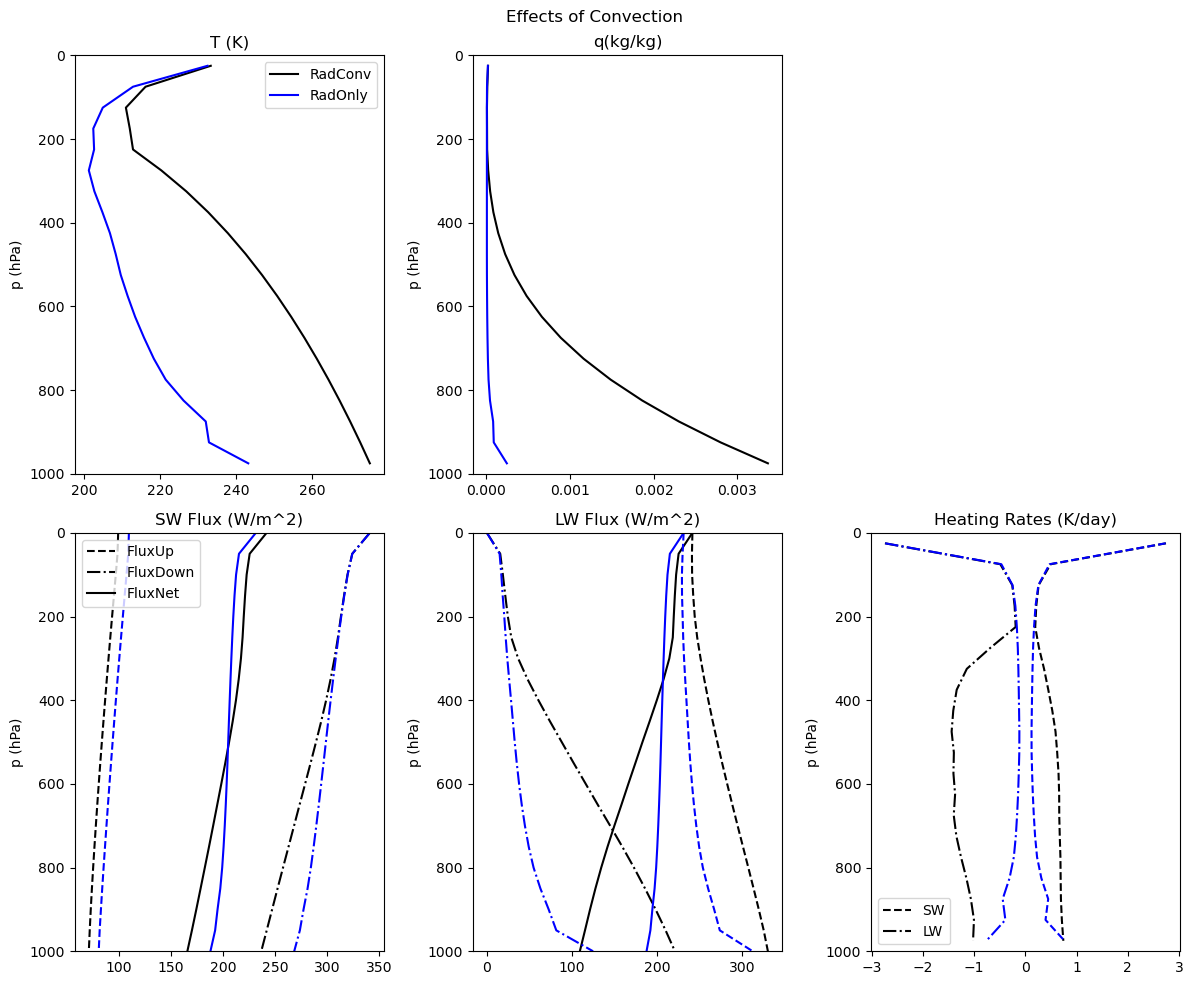

In [5]:
# make a plot of the data

makePlotsFromExperimentList([ds,ds_nc],['RadConv','RadOnly'],suptitle='Effects of Convection')

# Example 2 - the effect of clouds

In [6]:
# this creates cloud profiles similar to that of the global "average" cloud in table 3.5 from the Hartman textbook. 
# the height of the cloud is controlled by the index icld

# check how many levels are in the model 
nlev=len(ds.q)

# containers for cloud properties
cldfac=np.zeros(nlev)
clp=np.zeros(nlev)
cip=np.zeros(nlev)

# set the cloud properties at one vertical level

icld = -5
cldfac[icld] = 1.0
cip[icld] = 36

# run the simulations 
ds_cld_lo = getEquilRadConvColumn(
        cldfrac=cldfac, 
        clwp=clp, 
        ciwp = cip,  
        r_liq = 15,
        r_ice = 15,
        )

Total elapsed time is 9.993368783782378 years.


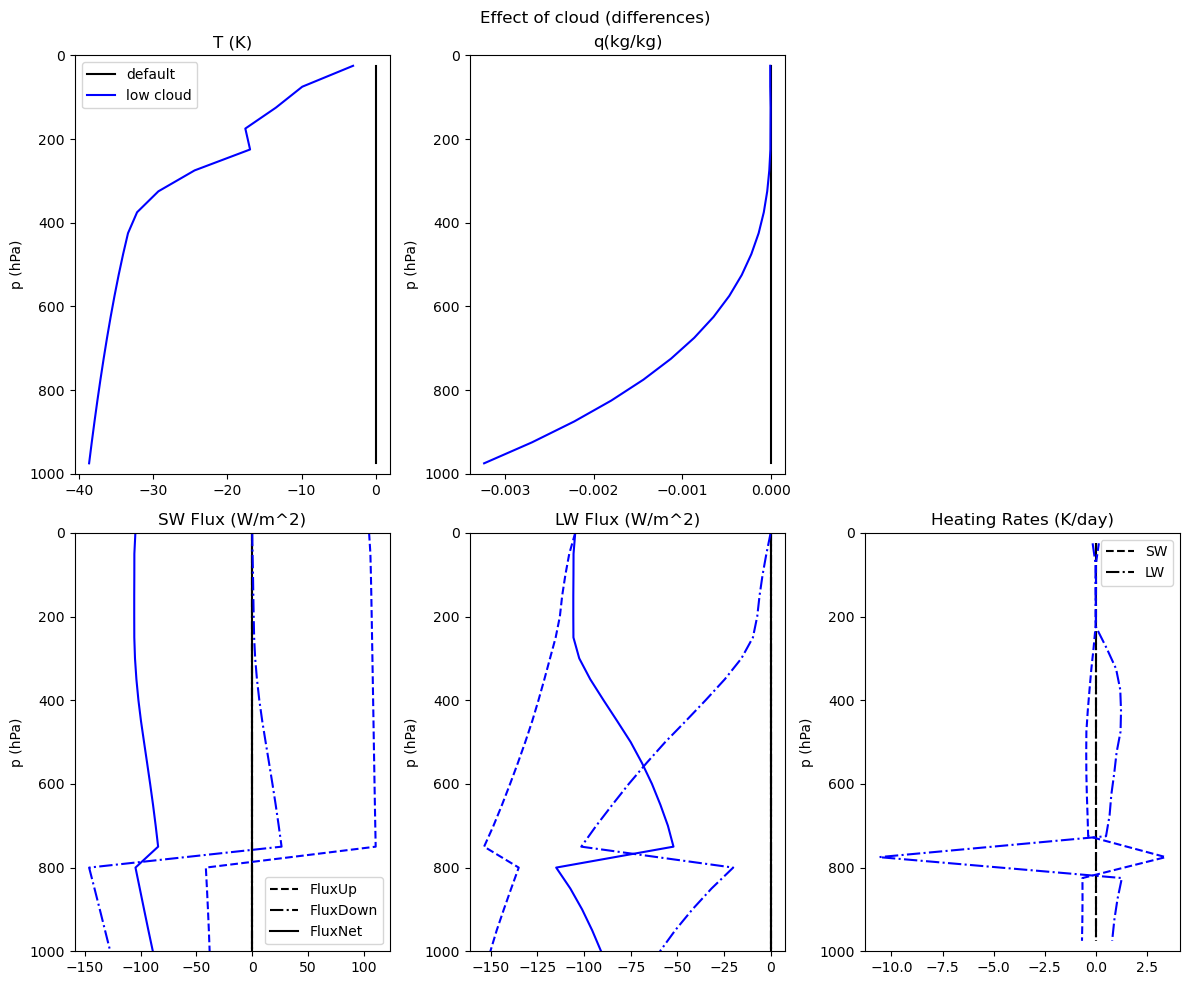

In [7]:
# make a plot showing the differences now 
makePlotsFromExperimentList([ds,ds_cld_lo],
                            ['default','low cloud'],
                            plotDiff=True,
                            suptitle='Effect of cloud (differences)')

# Questions {-}

## 1. Adding the radiative diagnostic to the model {-}

- How would you add a diagnostic to the output to show the net convective heating tendency? Add this to function makePlotsFromExperimentList.

- If you run the model, it says that it takes almost 7 years to equillibriate. If instead you stopped the model after 2 years, would you still be able to compute the convection in this way?

- Remake the plots for the radiative and radiative-convection solutions, but with the convective heating tendency. What is the effect of convection?

- Compare the net longwave at the top of the atmosphere between the two models. What explains which model has a higher net long wave at TOA, and what explains the magnitude of the difference?

## 2. Testing the model sensitivity varying the lapse rate {-}

- Rerun the model with the lapsrate set to 3 K/km and 9 K/km, and make a plot comparing to the default run.

- What do these lapse rates represent, compared to the default 6K/km? 

- What effect does changing the lapserate have on the vertical structure of the atmosphere? How does this relate to the heating rate?

- Compare the net longwave at the surface and at the top of atmosphere. Which has the biggest change, and why?

## 3. A cloud though experiment {-}

- Take the globally average cloud, and move it to 125 hPa instead of where it is currently, and plot the differences.

- What happens to the temperature profile, and why?

(in real life cloud properties and amounts will be different at different vertical levels in the atmosphere, here we are doing something very idealized in order to better understand the radiative effects.)